# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# Paths to directories

In [2]:
train_dir_img = '/kaggle/input/airbus-ship-detection/train_v2/'
test_dir_img = '/kaggle/input/airbus-ship-detection/test_v2/'
train_dir_csv = '/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv'
test_dir_csv = '/kaggle/input/airbus-ship-detection/sample_submission_v2.csv'

# Read and overview the train data

In [3]:
train_df = pd.read_csv(train_dir_csv)
train_df.head(10)

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8  0001b1832.jpg                                                NaN
9  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...

# Info about dataset

In [4]:
print('Number of masks (len of train_df): ', train_df.shape[0])
print('Unique images: ', len(train_df['ImageId'].unique()))
print('Images without ships: ', train_df['EncodedPixels'].isnull().sum())

Number of masks (len of train_df):  231723
Unique images:  192556
Images without ships:  150000


# Size of image

In [20]:
image_file = train_df['ImageId'].iloc[2]
image_path = train_dir_img + image_file  

image = cv2.imread(image_path)

height = image.shape[0]
width = image.shape[1]
num_channels = image.shape[2]
print('Size of image: ', height, width, num_channels)

Size of image:  768 768 3


# Vizualize image and mask

In [6]:
def decode_rle(encoded_pixels, shape):
    """
    Function to decode the RLE (Run-Length Encoding) encoded pixels into a binary mask image.

    Parameters:
        encoded_pixels (str): The RLE encoded pixel values.
        shape (tuple): The shape of the mask image (height, width).

    Returns:
        numpy.ndarray: The decoded binary mask image.

    """
    # Create an array to store the mask image
    mask_img = np.zeros((shape[0] * shape[1], 1), dtype=np.float32)
    
    # Check if the RLE encoding is not NaN (not a null value)
    if pd.notna(encoded_pixels):
        # Split the encoded pixels into a list of integers
        rle = list(map(int, encoded_pixels.split(' ')))
        pixel, pixel_count = [], []
        # Separate the pixel values and their counts into separate lists
        [pixel.append(rle[i] - 1) if i % 2 == 0 else pixel_count.append(rle[i]) for i in range(0, len(rle))]
        # Create a list of pixel ranges based on the pixel values and counts
        rle_pixels = [list(range(pixel[i], pixel[i] + pixel_count[i])) for i in range(0, len(pixel))]
        # Flatten the list of pixel ranges into a single list of pixel indices
        rle_mask_pixels = sum(rle_pixels, [])
        
        # Try to set the corresponding pixels in the mask image to 1 based on the RLE indices
        try:
            mask_img[rle_mask_pixels] = 1.
        # Catch any potential IndexError (e.g., if the RLE indices exceed the mask image dimensions)
        except IndexError:
            pass
    # Reshape the flattened mask image array into the original shape (transposed)
    return np.reshape(mask_img, shape).T

In [7]:
def encode_rle(mask_img):
    """
    Function to encode a binary mask image using RLE (Run-Length Encoding).

    Parameters:
        mask_img (numpy.ndarray): The binary mask image to be encoded.

    Returns:
        str: The RLE encoded pixel values.
    """
    # Flatten the mask image and convert it to a list of integers
    mask_flat = mask_img.T.flatten()

    # Initialize variables
    rle = []
    count = 0
    current_pixel = -1

    # Iterate through the flattened mask image
    for i, pixel in enumerate(mask_flat):
        if pixel == 1.:  # Check if the pixel value is 1. (indicating object presence)
            if current_pixel == -1:
                current_pixel = i
                count = 1
            else:
                count += 1
        else:
            if count > 0:
                rle.extend([current_pixel, count])
            current_pixel = -1
            count = 0

    # Append the last count and pixel value to the RLE list if count is non-zero
    if count > 0:
        rle.extend([current_pixel, count])
    
    if len(rle):
        encoded_rle = ' '.join(map(str, rle))
    else:
        encoded_rle = pd.NA

    return encoded_rle

In [8]:
def display_image_and_mask(image_path, mask):
    """
    Function to display an original image and its corresponding segmented mask.

    Parameters:
        image_path (str): The file path of the original image.
        mask (numpy.ndarray): The segmented mask image.

    Returns:
        None

    """
    # Read the original image and convert it from BGR to RGB format
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create a subplot with two axes for displaying the original image and the segmented mask
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(mask)
    axes[1].set_title('Segmented Image')
    axes[1].axis('off')

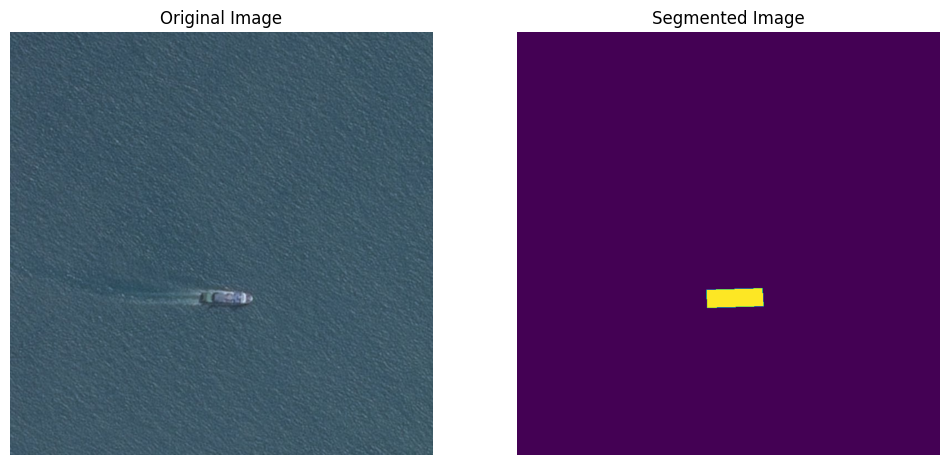

In [9]:
image_info = train_df.iloc[2]
image_path = train_dir_img + image_info['ImageId']
display_image_and_mask(image_path, decode_rle(image_info['EncodedPixels'], (height, width)))

# Ship area as a fraction of 1

In [10]:
def calculate_ship_area(encoded_rle, shape):
    """
    Function to calculate the area (percentage of total pixels) of a ship from its RLE encoded mask.

    Parameters:
        encoded_rle (str): The RLE encoded pixel values.
        shape (tuple): The shape (height, width) of the binary mask image.

    Returns:
        float: The area (percentage of total pixels) of the ship.
    """
    total_pixels = shape[0] * shape[1]

    # Decode RLE to get the binary mask image
    mask_img = decode_rle(encoded_rle, shape)

    # Calculate area as a percentage of total pixels
    area_percentage = (np.sum(mask_img) / total_pixels)

    return area_percentage


In [11]:
train_df['ShipArea'] = train_df.apply(lambda row: calculate_ship_area(row['EncodedPixels'], shape=(height, width)), axis=1)

print(train_df.head())

         ImageId                                      EncodedPixels  ShipArea
0  00003e153.jpg                                                NaN  0.000000
1  0001124c7.jpg                                                NaN  0.000000
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...  0.005744
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...  0.000300
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...  0.000251


# ShipArea distribution for original dataset

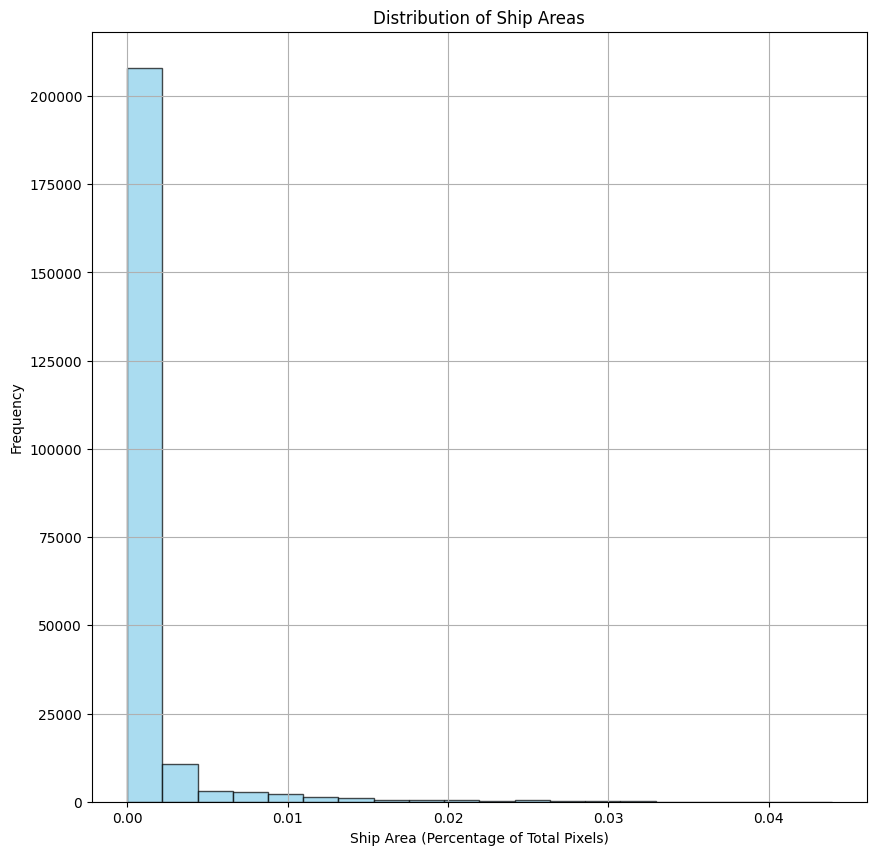

In [12]:
# Plotting the histogram
plt.figure(figsize=(10, 10))
plt.hist(train_df['ShipArea'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Ship Area (Percentage of Total Pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of Ship Areas')
plt.grid(True)
plt.show()

### Minimum and maximum, mean area of one ship

In [43]:
print('Min for orig dataset: ', min(train_df['ShipArea']))
print('Max for orig dataset: ', max(train_df['ShipArea']))
print('Mean for orig dataset: ',train_df['ShipArea'].mean())

Min for orig dataset:  0.0
Max for orig dataset:  0.04391818576388889
Mean for orig dataset:  0.0009372023095241162


# Group the ships on images

In [14]:
def combine_masks(encoded_pixels):
    """
    Function to combine multiple RLE-encoded masks into a single string.

    Parameters:
        encoded_pixels (list): A list of RLE-encoded pixel values.

    Returns:
        str: A string containing the combined RLE-encoded masks.

    """
    masks = ' '.join(map(str, encoded_pixels))
    return masks


def process_image(image_id, group):
    """
    Function to process an image group by combining multiple masks into a single combined mask.

    Parameters:
        image_id (str): The ID of the image.
        group (pandas.DataFrame): A DataFrame containing the image group.

    Returns:
        tuple: A tuple containing the image ID, combined mask, and the number of masks in the group.

    """
    # Extract the list of encoded pixels from the DataFrame group
    encoded_pixels = group['EncodedPixels'].tolist()
    
    # Check if all encoded pixels are not null
    if np.all(pd.notna(encoded_pixels)):
        # Combine the masks into a single string
        combined_mask = combine_masks(encoded_pixels)
        # Return the image ID, combined mask, and number of masks
        return image_id, combined_mask, len(group)
    else:
        # If any encoded pixels are null, return None values
        return image_id, None, 0  

In [15]:
# Group data by 'ImageId'
grouped_data = train_df.groupby('ImageId')

# Process each group and collect results
processed_results = [process_image(image_id, group) for image_id, group in grouped_data]

result_df = pd.DataFrame(processed_results, columns=['ImageId', 'CombinedMask', 'NumShips'])

In [16]:
result_df.head(100)

ImageId                                       CombinedMask  NumShips
0   00003e153.jpg                                               None         0
1   0001124c7.jpg                                               None         0
2   000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...         1
3   000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...         5
4   0001b1832.jpg                                               None         0
..            ...                                                ...       ...
95  001f04ca3.jpg                                               None         0
96  001f3caca.jpg                                               None         0
97  002077cf3.jpg                                               None         0
98  00207e662.jpg                                               None         0
99  002155dd1.jpg                                               None         0

[100 rows x 3 columns]

# Percentage of the number of ships 

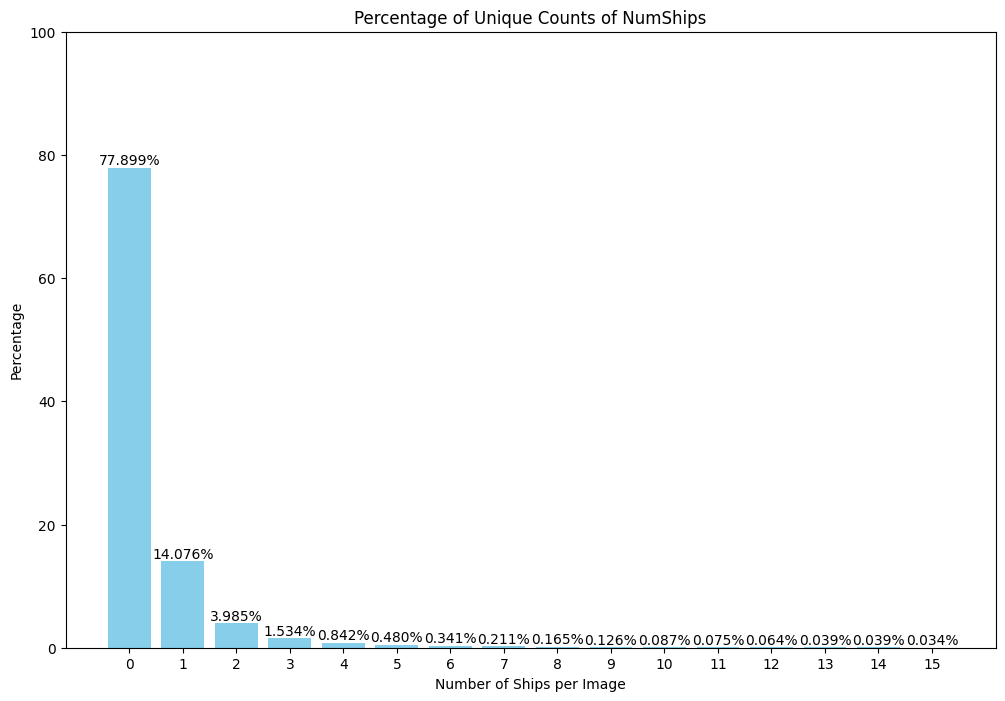

In [17]:
# Calculate the frequency and percentage of each unique count of NumShips
total_images = result_df.shape[0]
ship_counts = result_df['NumShips'].value_counts().sort_index()
ship_counts_percent = (ship_counts / total_images) * 100

# Plotting the bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(ship_counts.index, ship_counts_percent.values, color='skyblue')

# Annotating the bars with percentage values
for bar, percent in zip(bars, ship_counts_percent.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percent:.3f}%', ha='center', va='bottom')

plt.xlabel('Number of Ships per Image')
plt.ylabel('Percentage')
plt.title('Percentage of Unique Counts of NumShips')
plt.xticks(ship_counts.index)
plt.ylim(0, 100) 
plt.show()

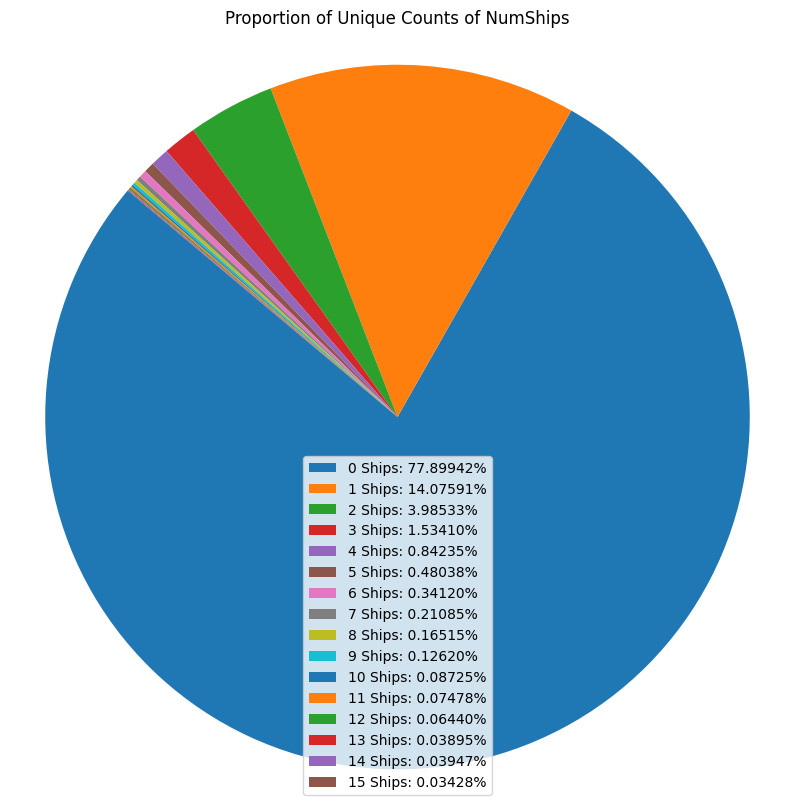

In [18]:
# Plotting the pie chart
plt.figure(figsize=(10, 10))
plt.pie(ship_counts, startangle=140)
plt.title('Proportion of Unique Counts of NumShips')

plt.legend(loc='best', labels=[f'{count} Ships: {percent:.5f}%' for count, percent in zip(ship_counts.index, ship_counts_percent)])
plt.axis('equal')
plt.show()

### We have large class imbalance between Images with ships and Images without ships

## ShipArea distribution for combined dataset

In [21]:
result_df['ShipArea'] = result_df.apply(lambda row: calculate_ship_area(row['CombinedMask'], shape=(height, width)), axis=1)

### Minimum and maximum area of ship group

In [44]:
print('Min for combined dataset: ', min(result_df['ShipArea']))
print('Max for combined dataset: ', max(result_df['ShipArea']))
print('Mean for combined dataset: ', result_df['ShipArea'].mean())

Min for combined dataset:  0.0
Max for combined dataset:  0.1300726996527778
Mean for combined dataset:  0.0011278346598904048


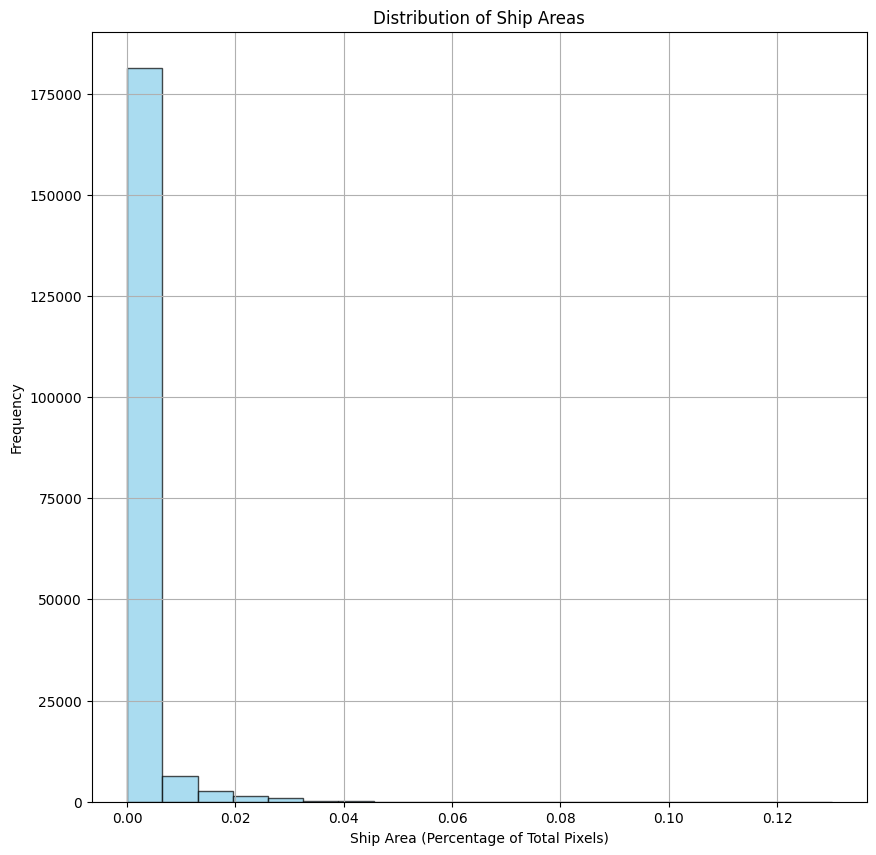

In [23]:
# Plotting the histogram
plt.figure(figsize=(10, 10))
plt.hist(result_df['ShipArea'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Ship Area (Percentage of Total Pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of Ship Areas')
plt.grid(True)
plt.show()

### We have a very small percentage of pixels with ships in the dataframe. Maybe we need to sort images by ShipArea.

# Vizualize images with different number of ships

### Number of ships in range (0, 15)

In [24]:
ship_ranges = [(0, 1), (2, 5), (6, 10), (11, 15)]  # Ranges

In [25]:
result_df.head()

ImageId                                       CombinedMask  NumShips  \
0  00003e153.jpg                                               None         0   
1  0001124c7.jpg                                               None         0   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...         1   
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...         5   
4  0001b1832.jpg                                               None         0   

   ShipArea  
0  0.000000  
1  0.000000  
2  0.005744  
3  0.002475  
4  0.000000

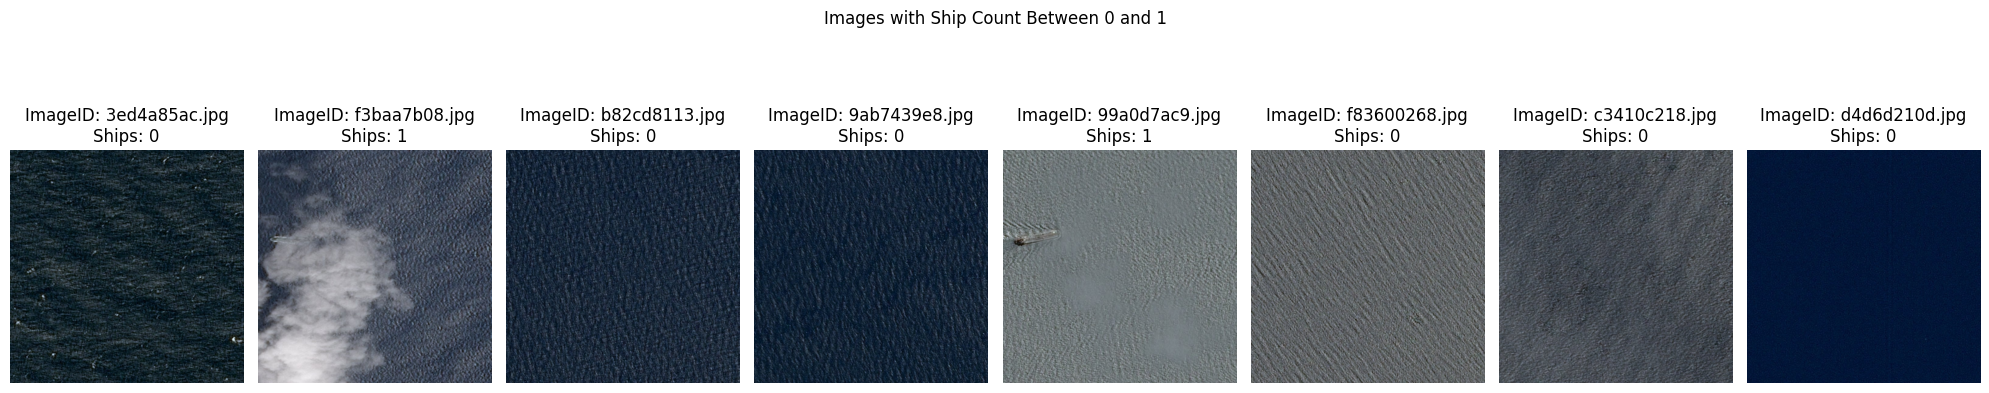

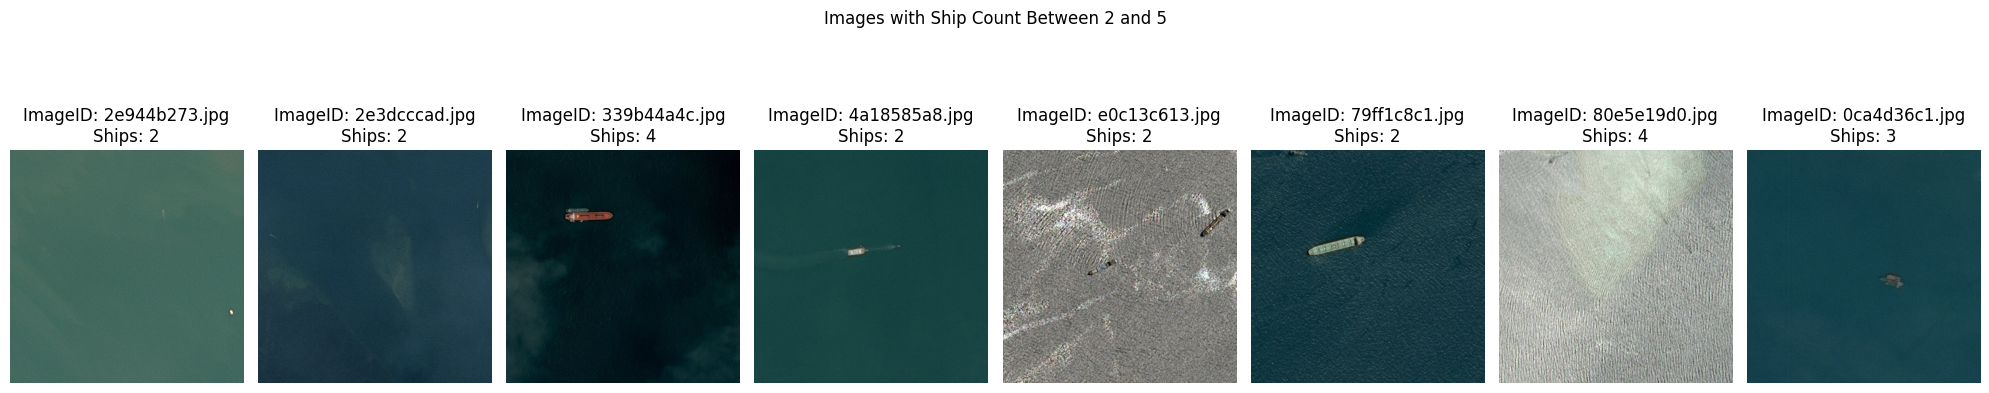

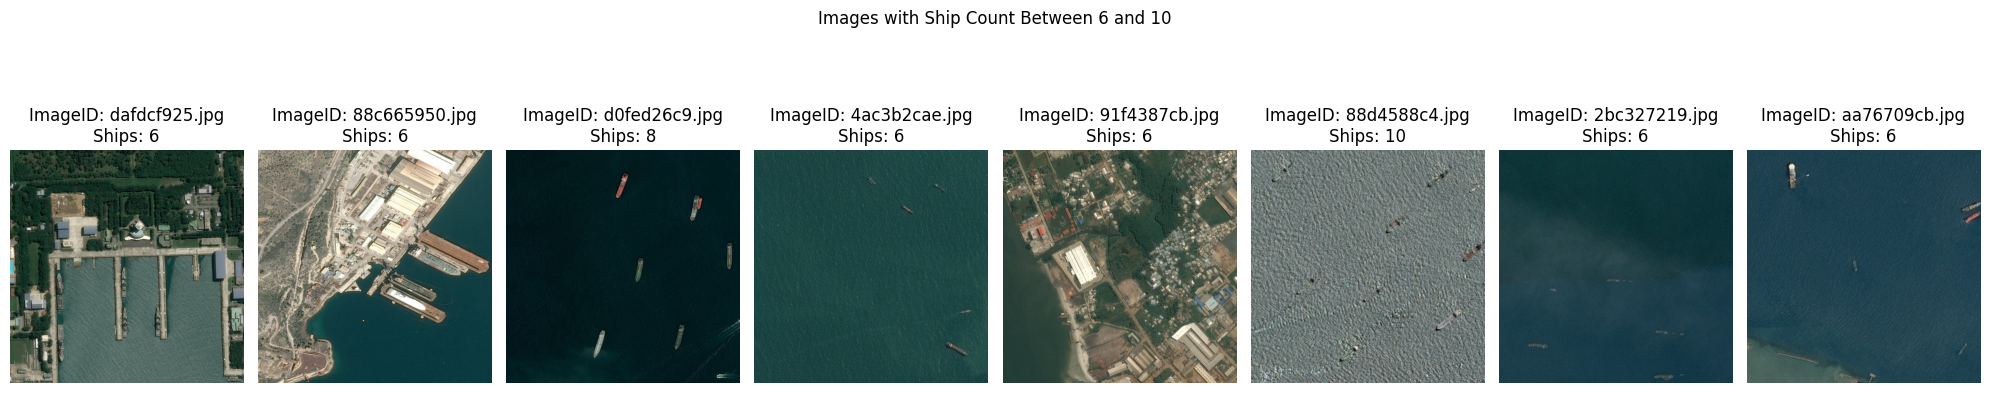

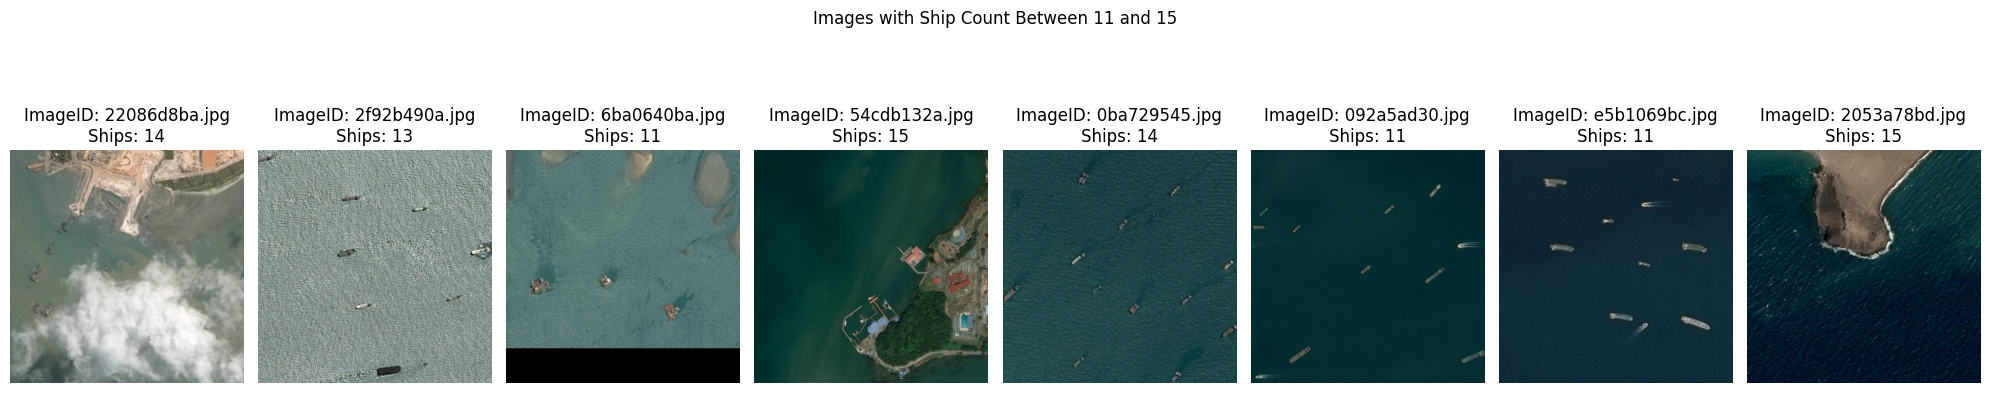

In [26]:
def visualize_images_by_ship_count(ranges, df, num_images=8):
    """
    Function to visualize images with a specified range of ship counts.

    Parameters:
        ranges (list of tuples): List of tuples specifying the ranges of ship counts to filter images.
        df (pandas.DataFrame): DataFrame containing image metadata including ship counts.
        num_images (int): Number of images to visualize for each range.

    """
    
    for low, high in ranges:
        filtered_df = df[(df['NumShips'] >= low) & (df['NumShips'] <= high)].sample(n=num_images, random_state=4747)
        
        fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
        
        for j, (index, row) in enumerate(filtered_df.iterrows()):
            image_id = row['ImageId']
            image_path = f"/kaggle/input/airbus-ship-detection/train_v2/{image_id}"  
            
            if os.path.exists(image_path):
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    axes[j].imshow(image)
                    axes[j].set_title(f"ImageID: {image_id}\nShips: {row['NumShips']}")
                else:
                    print(f"Warning: Image at path {image_path} could not be read.")
                    axes[j].set_title(f"ImageID: {image_id}\nShips: {row['NumShips']}\n[Image not found]")
            else:
                print(f"Warning: Image at path {image_path} does not exist.")
                axes[j].set_title(f"ImageID: {image_id}\nShips: {row['NumShips']}\n[Image not found]")
            
            axes[j].axis('off')
        
        plt.suptitle(f'Images with Ship Count Between {low} and {high}')
        plt.tight_layout()
        plt.show()

visualize_images_by_ship_count(ship_ranges, result_df)


# Total area with ships and No ships

In [27]:
total_pixels_per_image = width * height
result_df['ShipAreaPixels'] = result_df['ShipArea'] * total_pixels_per_image

In [38]:
total_ship_area_pixels = result_df['ShipAreaPixels'].sum()
print('Total pixels with ships:', total_ship_area_pixels)

Total pixels with ships: 128092863.0


In [36]:
total_area_pixels = total_pixels_per_image * len(result_df)
print('Total pixels:', total_area_pixels)

Total pixels 113574150144


In [39]:
# % pixels with ships
percent_pixels_with_ships = total_ship_area_pixels / total_area_pixels
print(f' % pixels with ships: {percent_pixels_with_ships * 100}%')

 % pixels with ships: 0.11278346598904047%


### very small number of pixels with ships. let's try to remove images without ships

## Delete images without ships

In [33]:
result_df_with_ships = result_df[result_df['NumShips'] > 0]

In [40]:
total_area_pixels = total_pixels_per_image * len(result_df_with_ships)
# % pixels with ships
percent_pixels_with_ships = total_ship_area_pixels / total_area_pixels
print(f' % pixels with ships: {percent_pixels_with_ships * 100}%')

 % pixels with ships: 0.5103189462587103%


### the situation has not improved much